# Hurricane Damage Detector

## Get and Load Dataset

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown --id 1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK
From (redirected): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK&confirm=t&uuid=bdf8af50-c7f6-4fc0-a743-41d758de4c8a
To: /content/hurricane_detector.zip
100% 39.7M/39.7M [00:00<00:00, 250MB/s]


In [ ]:
!unzip -q hurricane_detector.zip

replace train_hurricane/no_damage/-95.638504_29.838933.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
ls -l

total 38748
-rw-r--r-- 1 root root 39662128 Jun 23 13:19 hurricane_detector.zip
drwxr-xr-x 1 root root     4096 Jun 21 21:47 sample_data/
drwxr-xr-x 4 root root     4096 Jun 23 11:05 test_hurricane/
drwxr-xr-x 4 root root     4096 Jun 23 11:05 train_hurricane/


In [ ]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.8.0-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [ ]:
!tree --dirsfirst --filelimit 2 ./train_hurricane/

./train_hurricane/
├── damage [655 entries exceeds filelimit, not opening dir]
└── no_damage [703 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [ ]:
!tree --dirsfirst --filelimit 2 ./test_hurricane/

./test_hurricane/
├── damage [5895 entries exceeds filelimit, not opening dir]
└── no_damage [6333 entries exceeds filelimit, not opening dir]

2 directories, 0 files


## Load Dependencies

In [ ]:
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.12.0


## Utility functions to create dataset generators

In [ ]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions


### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10,
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [ ]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


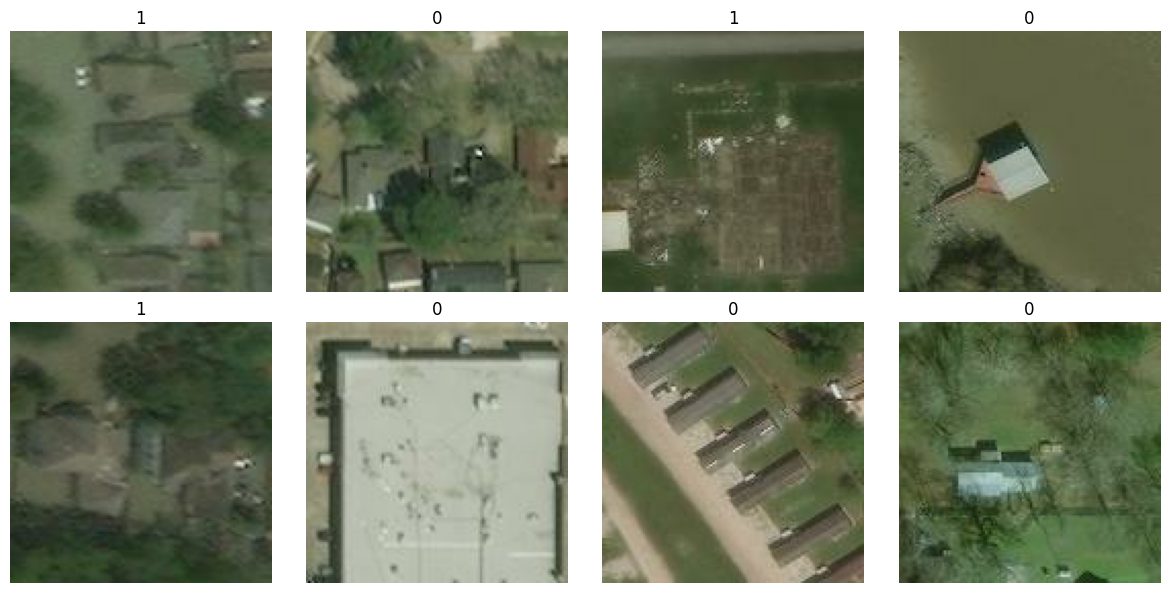

In [ ]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## If you want to apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def model_evaluation(y, predictions):
    xylabels = ['no_damage', 'damage']

    print(classification_report(y, predictions))
    print('----------------------------------------------------------')
    accuracy = accuracy_score(y, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100))
    print('----------------------------------------------------------')
    precision = precision_score(y, predictions, average = "weighted")
    print("Precision: %.2f%%" % (precision * 100))
    print('----------------------------------------------------------')
    recall = recall_score(y, predictions, average = "weighted")
    print("Recall: %.2f%%" % (recall * 100))
    print('----------------------------------------------------------')

    cf = confusion_matrix(y, predictions)
    sns.heatmap(cf, annot=True, fmt='.0f', xticklabels=xylabels, yticklabels=xylabels);

def show_graph(history, epochas):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochas)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
num_classes = 1
initial_epochs = 10

model_adam = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128,128, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model_adam.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),                     #BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model_adam.fit(
    train_ds, epochs=initial_epochs,
    validation_data=val_ds,
)

#y_true, y_pred = eval_model_on_test(model_adam)

Epoch 1/10
34/34 [==============================] - 4s 22ms/step - loss: 0.6907 - accuracy: 0.5409 - val_loss: 0.6491 - val_accuracy: 0.8007
Epoch 2/10
34/34 [==============================] - 1s 19ms/step - loss: 0.5599 - accuracy: 0.7433 - val_loss: 0.4865 - val_accuracy: 0.8413
Epoch 3/10
34/34 [==============================] - 1s 20ms/step - loss: 0.4260 - accuracy: 0.8344 - val_loss: 0.4328 - val_accuracy: 0.8192
Epoch 4/10
34/34 [==============================] - 1s 20ms/step - loss: 0.3244 - accuracy: 0.8776 - val_loss: 0.3524 - val_accuracy: 0.8672
Epoch 5/10
34/34 [==============================] - 1s 19ms/step - loss: 0.3193 - accuracy: 0.8721 - val_loss: 0.3856 - val_accuracy: 0.8672
Epoch 6/10
34/34 [==============================] - 1s 18ms/step - loss: 0.2249 - accuracy: 0.9144 - val_loss: 0.3674 - val_accuracy: 0.8708
Epoch 7/10
34/34 [==============================] - 1s 17ms/step - loss: 0.1749 - accuracy: 0.9310 - val_loss: 0.3147 - val_accuracy: 0.8819
Epoch 8/10
34

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   1%|          | 1/96 [00:00<00:47,  2.00it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:00<00:30,  3.11it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:00<00:22,  4.14it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:01<00:25,  3.66it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:01<00:24,  3.70it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:01<00:22,  3.95it/s]

4/4 [==============================] - 0s 15ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:01<00:23,  3.85it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:02<00:22,  3.87it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:02<00:22,  3.95it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:02<00:22,  3.91it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:02<00:21,  4.03it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:03<00:20,  4.11it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:03<00:20,  4.12it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:03<00:17,  4.64it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:03<00:16,  4.94it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:03<00:14,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:04<00:14,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:04<00:13,  5.95it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:04<00:13,  5.85it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:04<00:12,  6.13it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:04<00:11,  6.35it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:04<00:11,  6.58it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:04<00:10,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:05<00:10,  6.94it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:05<00:09,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:05<00:10,  6.50it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:05<00:10,  6.29it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:05<00:11,  6.15it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:05<00:10,  6.49it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:05<00:09,  6.72it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:06<00:09,  6.85it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:06<00:10,  6.39it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:06<00:09,  6.30it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:06<00:09,  6.43it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:06<00:09,  6.64it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:06<00:09,  6.44it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:07<00:09,  6.33it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:07<00:08,  6.60it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:07<00:08,  6.85it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:07<00:08,  6.57it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:07<00:08,  6.69it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:07<00:07,  6.94it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:07<00:07,  6.88it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:08<00:07,  6.90it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:08<00:07,  6.56it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:08<00:08,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:08<00:07,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:08<00:07,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:08<00:06,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:08<00:06,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:09<00:06,  7.26it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:09<00:06,  6.82it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:09<00:06,  6.47it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:09<00:06,  6.33it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:09<00:06,  6.45it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:09<00:06,  6.33it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:10<00:05,  6.69it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:10<00:05,  6.49it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:10<00:05,  6.63it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:10<00:05,  6.41it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:10<00:05,  6.54it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:10<00:05,  6.31it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:11<00:05,  6.25it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:11<00:05,  6.20it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:11<00:04,  6.22it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:11<00:04,  6.32it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:11<00:04,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:11<00:04,  6.83it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:11<00:03,  6.75it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:12<00:03,  6.85it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:12<00:03,  6.58it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:12<00:03,  6.43it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:12<00:03,  6.14it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:12<00:03,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:12<00:03,  6.35it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:12<00:03,  6.65it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:13<00:03,  6.23it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:13<00:02,  6.43it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:13<00:02,  6.00it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:13<00:02,  5.80it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:13<00:02,  5.29it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:14<00:02,  5.05it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:14<00:02,  4.99it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:14<00:02,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:14<00:02,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:15<00:02,  4.66it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:15<00:01,  4.81it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:15<00:01,  4.91it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:15<00:01,  5.03it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:15<00:01,  5.10it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:15<00:00,  5.34it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:16<00:00,  5.57it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:16<00:00,  5.74it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:16<00:00,  6.11it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:16<00:00,  6.19it/s]

3/3 [==============================] - 0s 6ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:20<00:00,  4.69it/s]


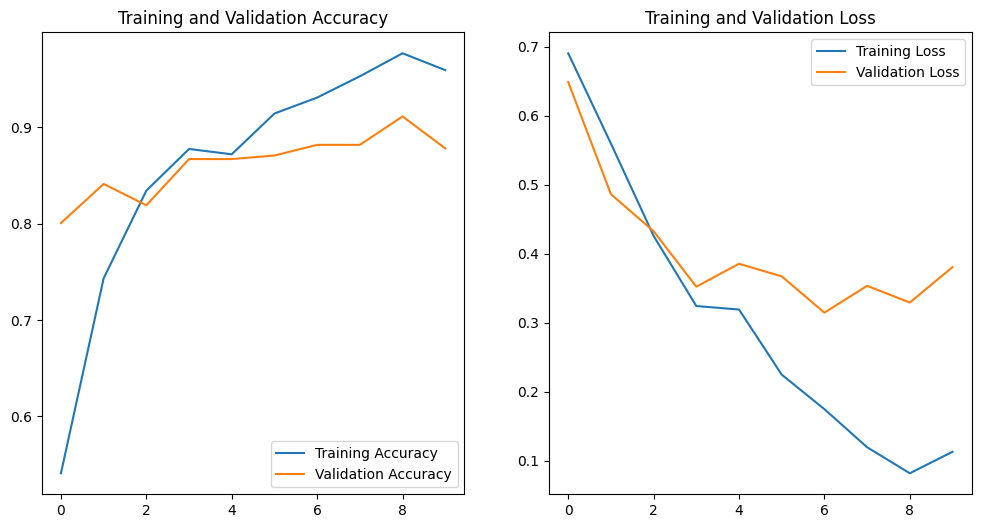

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion Matrix & Model Evaluation

In [ ]:
y_true.size, y_pred.size

(12228, 12228)

In [ ]:
y_pred = pd.DataFrame(y_pred)[0].apply(lambda x : 1 if x > 0.5 else 0)
y_pred

0        1
1        0
2        1
3        0
4        0
        ..
12223    1
12224    1
12225    0
12226    1
12227    1
Name: 0, Length: 12228, dtype: int64

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      6333
           1       0.87      0.86      0.87      5895

    accuracy                           0.87     12228
   macro avg       0.87      0.87      0.87     12228
weighted avg       0.87      0.87      0.87     12228

----------------------------------------------------------
Accuracy: 87.36%
----------------------------------------------------------
Precision: 87.36%
----------------------------------------------------------
Recall: 87.36%
----------------------------------------------------------


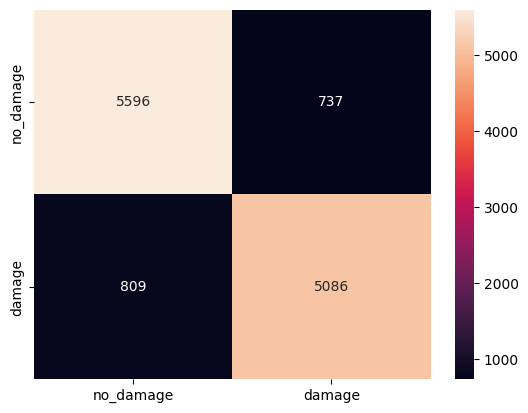

In [ ]:
model_evaluation (y_true, y_pred)

In [ ]:
num_classes = 1
initial_epochs = 10

model_sgd = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128,128, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='sigmoid')
])

model_sgd.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(),                     #BinaryCrossentropy(),
              metrics=['accuracy'])

history = model_sgd.fit(
    train_ds, epochs=initial_epochs,
    validation_data=val_ds,
)

y_true, y_pred_sgd = eval_model_on_test(model_sgd)

Epoch 1/10
34/34 [==============================] - 2s 21ms/step - loss: 0.6890 - accuracy: 0.5124 - val_loss: 0.6799 - val_accuracy: 0.5424
Epoch 2/10
34/34 [==============================] - 1s 20ms/step - loss: 0.6828 - accuracy: 0.5124 - val_loss: 0.6745 - val_accuracy: 0.5424
Epoch 3/10
34/34 [==============================] - 1s 19ms/step - loss: 0.6782 - accuracy: 0.5152 - val_loss: 0.6702 - val_accuracy: 0.5609
Epoch 4/10
34/34 [==============================] - 1s 19ms/step - loss: 0.6707 - accuracy: 0.5796 - val_loss: 0.6625 - val_accuracy: 0.5535
Epoch 5/10
34/34 [==============================] - 1s 24ms/step - loss: 0.6635 - accuracy: 0.6182 - val_loss: 0.6557 - val_accuracy: 0.5572
Epoch 6/10
34/34 [==============================] - 1s 33ms/step - loss: 0.6564 - accuracy: 0.6256 - val_loss: 0.6535 - val_accuracy: 0.7675
Epoch 7/10
34/34 [==============================] - 1s 26ms/step - loss: 0.6408 - accuracy: 0.6918 - val_loss: 0.6511 - val_accuracy: 0.6900
Epoch 8/10
34

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:   1%|          | 1/96 [00:00<00:45,  2.07it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:01<00:53,  1.77it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:01<00:35,  2.62it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:01<00:26,  3.41it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:01<00:22,  4.07it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:01<00:19,  4.51it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:01<00:17,  5.01it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:02<00:16,  5.37it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:02<00:15,  5.64it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:02<00:15,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:02<00:14,  5.71it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:02<00:15,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:02<00:14,  5.89it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:03<00:13,  6.04it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:03<00:13,  5.87it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:03<00:14,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:03<00:14,  5.64it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:03<00:14,  5.47it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:03<00:14,  5.50it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:04<00:13,  5.72it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:04<00:13,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:04<00:12,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:04<00:13,  5.53it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:04<00:13,  5.53it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:05<00:12,  5.79it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:05<00:12,  5.62it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:05<00:11,  5.80it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:05<00:11,  6.05it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:05<00:11,  5.79it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:05<00:11,  5.98it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:06<00:11,  5.89it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:06<00:10,  6.05it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:06<00:10,  6.17it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:06<00:10,  6.16it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:06<00:09,  6.32it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:06<00:09,  6.28it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:07<00:09,  6.24it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:07<00:09,  5.96it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:07<00:10,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:07<00:11,  4.89it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:07<00:11,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:08<00:12,  4.49it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:08<00:12,  4.31it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:08<00:12,  4.24it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:08<00:12,  4.22it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:09<00:12,  4.17it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:09<00:12,  4.07it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:09<00:11,  4.19it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:09<00:10,  4.68it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:09<00:09,  4.92it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:10<00:08,  5.08it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:10<00:08,  5.42it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:10<00:07,  5.58it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:10<00:07,  5.79it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:10<00:07,  5.61it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:11<00:07,  5.41it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:11<00:07,  5.39it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:11<00:07,  5.20it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:11<00:06,  5.52it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:11<00:06,  5.81it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:11<00:06,  5.64it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:12<00:05,  5.91it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:12<00:05,  5.69it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:12<00:05,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:12<00:05,  5.98it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:12<00:04,  6.10it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:12<00:04,  5.82it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:13<00:04,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:13<00:04,  5.64it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:13<00:04,  5.61it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:13<00:04,  5.55it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:13<00:04,  5.67it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:13<00:04,  5.58it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:14<00:03,  5.57it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:14<00:03,  5.67it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:14<00:03,  5.63it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:14<00:03,  5.86it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:14<00:03,  5.76it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:15<00:02,  5.93it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:15<00:02,  6.07it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:15<00:02,  5.97it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:15<00:02,  6.07it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:15<00:02,  5.72it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:15<00:02,  5.76it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:16<00:01,  5.84it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:16<00:01,  5.81it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:16<00:01,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:16<00:01,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:16<00:00,  7.02it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:16<00:00,  6.79it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:16<00:00,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:17<00:00,  6.33it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:17<00:00,  6.70it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:17<00:00,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:17<00:00,  7.18it/s]

3/3 [==============================] - 0s 5ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:20<00:00,  4.69it/s]


              precision    recall  f1-score   support

           0       0.54      0.99      0.70      6333
           1       0.91      0.09      0.16      5895

    accuracy                           0.56     12228
   macro avg       0.72      0.54      0.43     12228
weighted avg       0.72      0.56      0.44     12228

----------------------------------------------------------
Accuracy: 55.70%
----------------------------------------------------------
Precision: 71.63%
----------------------------------------------------------
Recall: 55.70%
----------------------------------------------------------


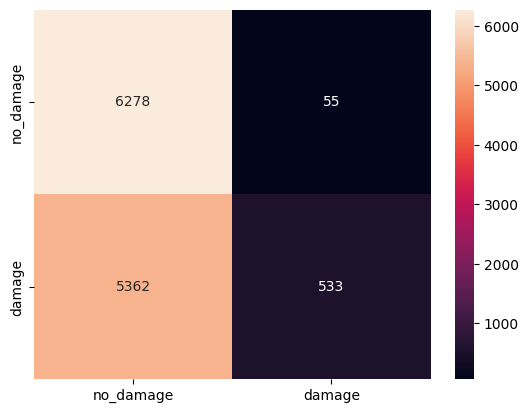

In [ ]:
y_pred_sgd = pd.DataFrame(y_pred_sgd)[0].apply(lambda x : 1 if x > 0.5 else 0)
model_evaluation (y_true, y_pred_sgd)

Using SGD did result in a significantly worse result

Implement more layers

In [ ]:
num_classes = 1
initial_epochs = 10

model_adam2 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128,128, 3)),
  layers.Conv2D(4, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='sigmoid')
])

model_adam2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),                     #BinaryCrossentropy(),
              metrics=['accuracy'])

history = model_adam2.fit(
    train_ds, epochs=initial_epochs,
    validation_data=val_ds,
)

y_true, y_pred_adam2 = eval_model_on_test(model_adam2)

Epoch 1/10
34/34 [==============================] - 4s 20ms/step - loss: 0.6767 - accuracy: 0.5428 - val_loss: 0.6326 - val_accuracy: 0.7860
Epoch 2/10
34/34 [==============================] - 1s 18ms/step - loss: 0.5490 - accuracy: 0.7617 - val_loss: 0.4649 - val_accuracy: 0.8118
Epoch 3/10
34/34 [==============================] - 1s 18ms/step - loss: 0.4613 - accuracy: 0.8096 - val_loss: 0.4260 - val_accuracy: 0.8413
Epoch 4/10
34/34 [==============================] - 1s 19ms/step - loss: 0.4003 - accuracy: 0.8169 - val_loss: 0.5888 - val_accuracy: 0.7380
Epoch 5/10
34/34 [==============================] - 1s 17ms/step - loss: 0.3930 - accuracy: 0.8362 - val_loss: 0.3712 - val_accuracy: 0.8450
Epoch 6/10
34/34 [==============================] - 1s 18ms/step - loss: 0.3468 - accuracy: 0.8592 - val_loss: 0.3350 - val_accuracy: 0.8708
Epoch 7/10
34/34 [==============================] - 1s 18ms/step - loss: 0.3235 - accuracy: 0.8602 - val_loss: 0.4102 - val_accuracy: 0.8450
Epoch 8/10
34

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   1%|          | 1/96 [00:00<01:12,  1.30it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:00<00:38,  2.43it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:01<00:26,  3.45it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:01<00:22,  4.07it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:01<00:18,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:01<00:17,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:01<00:15,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:01<00:14,  6.17it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:02<00:14,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:02<00:13,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:02<00:14,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:02<00:13,  6.05it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:02<00:13,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:02<00:14,  5.81it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:03<00:13,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:03<00:13,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:03<00:13,  5.90it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:03<00:13,  5.87it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:03<00:13,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:03<00:13,  5.84it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:04<00:12,  6.13it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:04<00:11,  6.40it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:04<00:12,  6.06it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:04<00:11,  6.03it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:04<00:11,  6.06it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:04<00:11,  6.03it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:05<00:11,  6.05it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:05<00:10,  6.19it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:05<00:10,  6.18it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:05<00:10,  6.05it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:05<00:10,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:05<00:10,  6.31it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:05<00:09,  6.70it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:06<00:09,  6.47it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:06<00:09,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:06<00:09,  6.11it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:06<00:09,  6.42it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:06<00:08,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:06<00:09,  6.20it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:07<00:08,  6.26it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:07<00:08,  6.17it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:07<00:09,  5.91it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:07<00:08,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:07<00:08,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:07<00:08,  6.31it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:08<00:08,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:08<00:07,  6.29it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:08<00:07,  6.16it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:08<00:07,  6.11it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:08<00:07,  6.38it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:08<00:06,  6.61it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:08<00:06,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:09<00:06,  6.46it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:09<00:06,  6.26it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:09<00:06,  5.87it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:09<00:06,  5.84it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:09<00:06,  5.80it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:10<00:06,  5.87it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:10<00:06,  5.86it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:10<00:05,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:10<00:05,  5.96it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:10<00:05,  5.97it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:10<00:05,  5.73it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:11<00:06,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:11<00:06,  5.01it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:11<00:06,  4.79it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:11<00:06,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:12<00:06,  4.54it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:12<00:06,  4.41it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:12<00:05,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:12<00:05,  4.35it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:12<00:05,  4.31it/s]

4/4 [==============================] - 0s 11ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:13<00:05,  4.32it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:13<00:04,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:13<00:04,  5.01it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:13<00:03,  5.29it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:13<00:03,  5.70it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:14<00:03,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:14<00:02,  5.73it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:14<00:02,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:14<00:02,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:14<00:02,  5.93it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:14<00:02,  6.17it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:14<00:01,  6.13it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:15<00:01,  6.36it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:15<00:01,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:15<00:01,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:15<00:01,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:15<00:00,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:15<00:00,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:15<00:00,  7.60it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:16<00:00,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:16<00:00,  7.29it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:16<00:00,  7.56it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:16<00:00,  7.73it/s]

3/3 [==============================] - 0s 5ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:16<00:00,  5.76it/s]


              precision    recall  f1-score   support

           0       0.94      0.82      0.88      6333
           1       0.83      0.94      0.89      5895

    accuracy                           0.88     12228
   macro avg       0.89      0.88      0.88     12228
weighted avg       0.89      0.88      0.88     12228

----------------------------------------------------------
Accuracy: 88.24%
----------------------------------------------------------
Precision: 88.93%
----------------------------------------------------------
Recall: 88.24%
----------------------------------------------------------


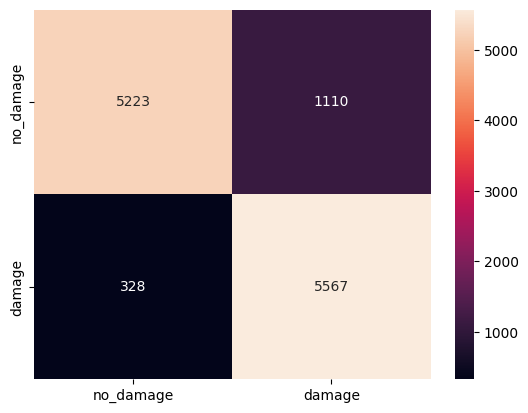

In [ ]:
y_pred_adam2 = pd.DataFrame(y_pred_adam2)[0].apply(lambda x : 1 if x > 0.5 else 0)

confusion = pd.DataFrame(confusion_matrix(y_true, y_pred_adam2),
             columns=[0,1], index=[0,1])

model_evaluation (y_true, y_pred_adam2)

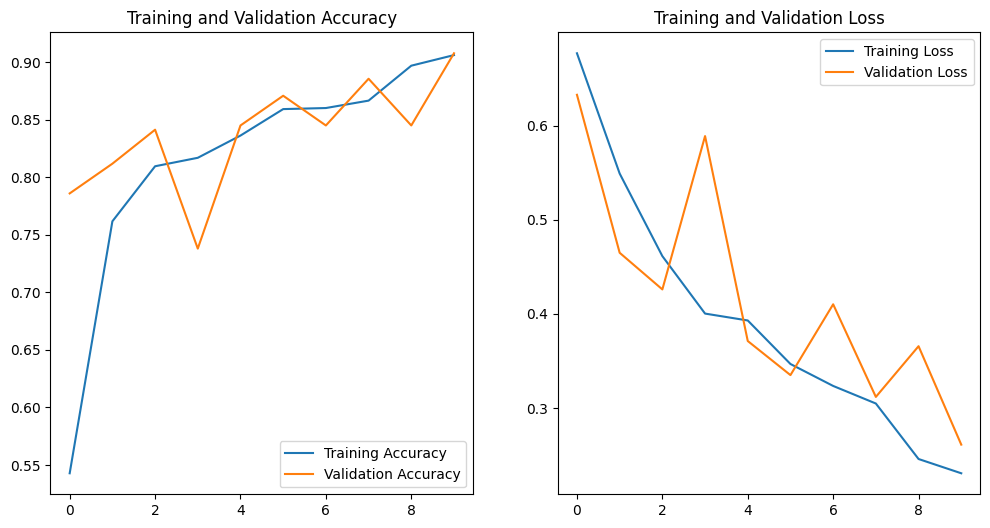

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Adding more layers leads to slightly better results. Now starting with Pretrained VGG16 model

In [149]:
pretrained_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet')

pretrained_model.trainable = False

In [150]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [151]:
model_VG = Sequential(
    [layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128,128, 3)),
    pretrained_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')] )

In [152]:
base_learning_rate = 0.0001
model_VG.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [153]:
history = model_VG.fit(
    train_ds, epochs=initial_epochs,
    validation_data=val_ds,
)

#y_true, y_pred_VG = eval_model_on_test(model_VG)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


34/34 [==============================] - 5s 63ms/step - loss: 0.5757 - accuracy: 0.7820 - val_loss: 0.3443 - val_accuracy: 0.8598
Epoch 2/10
34/34 [==============================] - 2s 53ms/step - loss: 0.2304 - accuracy: 0.9135 - val_loss: 0.2768 - val_accuracy: 0.8819
Epoch 3/10
34/34 [==============================] - 2s 54ms/step - loss: 0.1743 - accuracy: 0.9319 - val_loss: 0.2768 - val_accuracy: 0.8819
Epoch 4/10
34/34 [==============================] - 2s 52ms/step - loss: 0.1365 - accuracy: 0.9512 - val_loss: 0.2913 - val_accuracy: 0.8967
Epoch 5/10
34/34 [==============================] - 2s 52ms/step - loss: 0.1247 - accuracy: 0.9604 - val_loss: 0.2614 - val_accuracy: 0.9041
Epoch 6/10
34/34 [==============================] - 2s 53ms/step - loss: 0.0852 - accuracy: 0.9724 - val_loss: 0.2592 - val_accuracy: 0.9004
Epoch 7/10
34/34 [==============================] - 2s 53ms/step - loss: 0.0742 - accuracy: 0.9788 - val_loss: 0.2807 - val_accuracy: 0.9004
Epoch 8/10
34/34 [======

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      6333
           1       0.92      0.92      0.92      5895

    accuracy                           0.92     12228
   macro avg       0.92      0.92      0.92     12228
weighted avg       0.92      0.92      0.92     12228

----------------------------------------------------------
Accuracy: 92.10%
----------------------------------------------------------
Precision: 92.10%
----------------------------------------------------------
Recall: 92.10%
----------------------------------------------------------


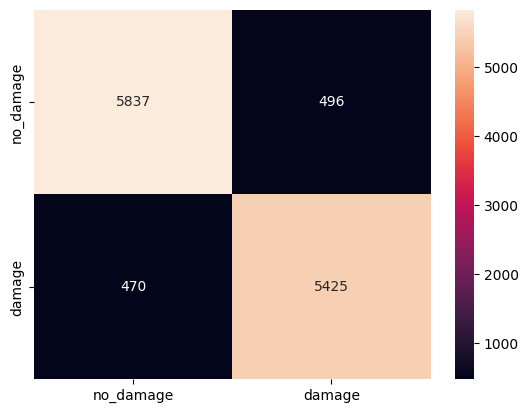

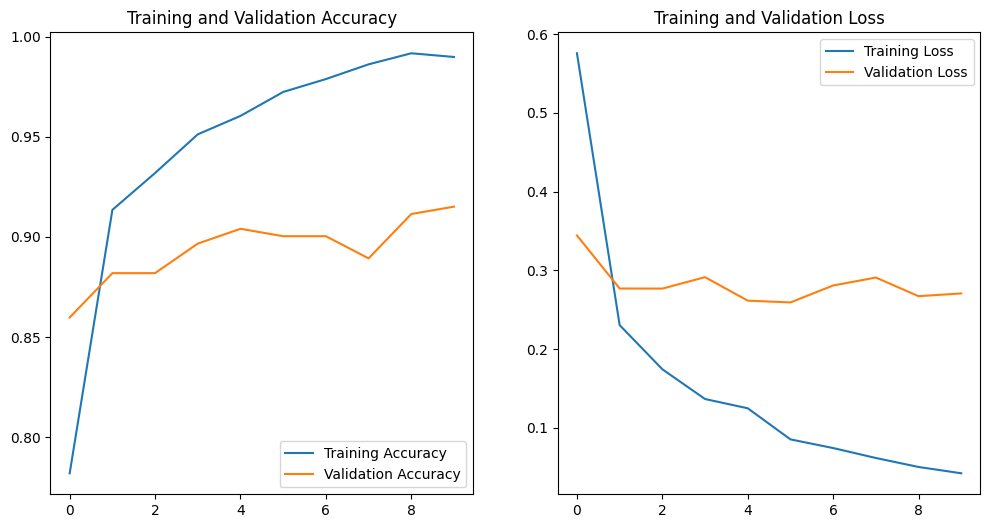

In [154]:
y_pred_VG = pd.DataFrame(y_pred_VG)[0].apply(lambda x : 1 if x > 0.5 else 0)

model_evaluation (y_true, y_pred_VG)

show_graph (history, 10)

Using the other model (til now completely frozen) helped improving the score a little. Let's see, what happens if we unfreeze the layers

In [155]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [156]:
pretrained_model.trainable = True

# fine-tune from this layer onwards
fine_tune_at = 15

# freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [172]:
model_VG.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/75),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_VG.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 8192)              0         
                                                                 
 dense_18 (Dense)            (None, 256)               2097408   
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [158]:
len(model_VG.trainable_variables)

10

In [159]:
fine_tune_epochs = 20
total_epochs =  30

history = model_VG.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]+1,

    validation_data=val_ds,
)

#y_true, y_pred_VG = eval_model_on_test(model_VG)

Epoch 11/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


34/34 [==============================] - 5s 70ms/step - loss: 4.8169 - accuracy: 0.6090 - val_loss: 0.5047 - val_accuracy: 0.7638
Epoch 12/30
34/34 [==============================] - 2s 62ms/step - loss: 0.4070 - accuracy: 0.8353 - val_loss: 0.3678 - val_accuracy: 0.8782
Epoch 13/30
34/34 [==============================] - 2s 71ms/step - loss: 0.4131 - accuracy: 0.8316 - val_loss: 0.3436 - val_accuracy: 0.8967
Epoch 14/30
34/34 [==============================] - 2s 62ms/step - loss: 0.2560 - accuracy: 0.8979 - val_loss: 0.2825 - val_accuracy: 0.9077
Epoch 15/30
34/34 [==============================] - 2s 62ms/step - loss: 0.2339 - accuracy: 0.9025 - val_loss: 0.2888 - val_accuracy: 0.9225
Epoch 16/30
34/34 [==============================] - 2s 61ms/step - loss: 0.2118 - accuracy: 0.9255 - val_loss: 0.3585 - val_accuracy: 0.9041
Epoch 17/30
34/34 [==============================] - 2s 62ms/step - loss: 0.2025 - accuracy: 0.9292 - val_loss: 0.2751 - val_accuracy: 0.9077
Epoch 18/30
34/34 

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      6333
           1       0.92      0.92      0.92      5895

    accuracy                           0.92     12228
   macro avg       0.92      0.92      0.92     12228
weighted avg       0.92      0.92      0.92     12228

----------------------------------------------------------
Accuracy: 92.10%
----------------------------------------------------------
Precision: 92.10%
----------------------------------------------------------
Recall: 92.10%
----------------------------------------------------------


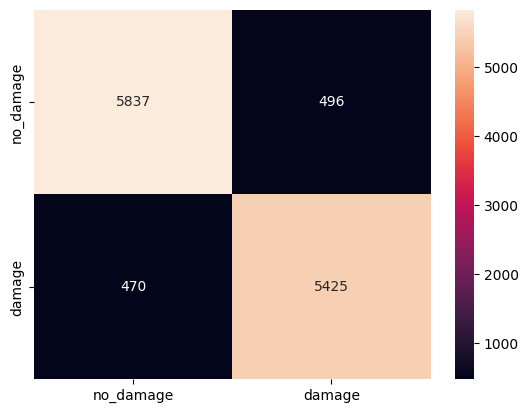

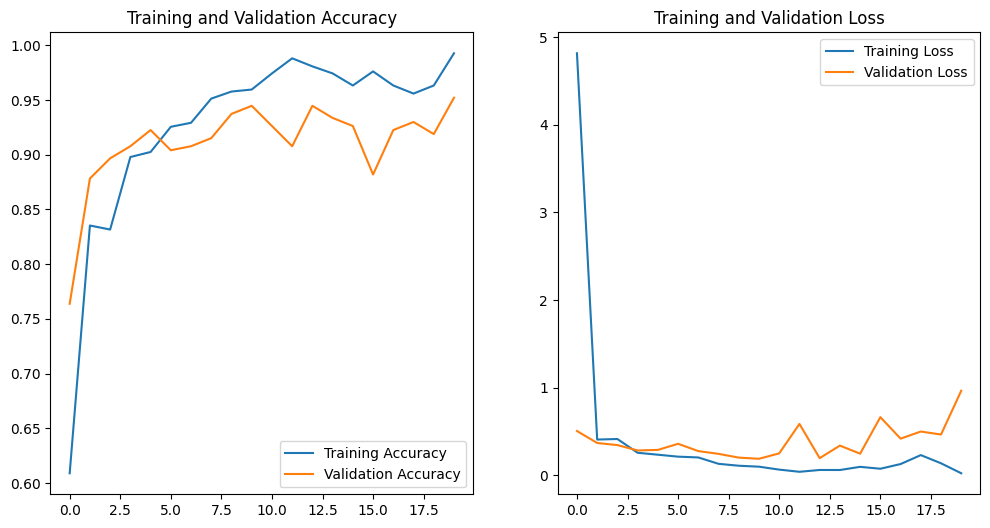

In [160]:
y_pred_VG = pd.DataFrame(y_pred_VG)[0].apply(lambda x : 1 if x > 0.5 else 0)

model_evaluation (y_true, y_pred_VG)

show_graph (history, 20)

In [161]:
pretrained_model.trainable = True

# fine-tune from this layer onwards
fine_tune_at = 10

# freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [162]:
len(model_VG.trainable_variables)

16

In [163]:
fine_tune_epochs2 = 20
total_epochs =  50

history = model_VG.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch= 30,

    validation_data=val_ds,
)

#y_true, y_pred_VG = eval_model_on_test(model_VG)

#show_graph(history, 10)

Epoch 31/50
34/34 [==============================] - 2s 63ms/step - loss: 1.0572 - accuracy: 0.9347 - val_loss: 0.3970 - val_accuracy: 0.9077
Epoch 32/50
34/34 [==============================] - 2s 63ms/step - loss: 0.3184 - accuracy: 0.8970 - val_loss: 0.4006 - val_accuracy: 0.9225
Epoch 33/50
34/34 [==============================] - 2s 63ms/step - loss: 0.1101 - accuracy: 0.9614 - val_loss: 0.2657 - val_accuracy: 0.9446
Epoch 34/50
34/34 [==============================] - 3s 73ms/step - loss: 0.0520 - accuracy: 0.9807 - val_loss: 0.2898 - val_accuracy: 0.9446
Epoch 35/50
34/34 [==============================] - 2s 64ms/step - loss: 0.0348 - accuracy: 0.9880 - val_loss: 0.3896 - val_accuracy: 0.9262
Epoch 36/50
34/34 [==============================] - 2s 62ms/step - loss: 0.0342 - accuracy: 0.9834 - val_loss: 0.3321 - val_accuracy: 0.9520
Epoch 37/50
34/34 [==============================] - 2s 63ms/step - loss: 0.0136 - accuracy: 0.9945 - val_loss: 0.5306 - val_accuracy: 0.9446
Epoch 

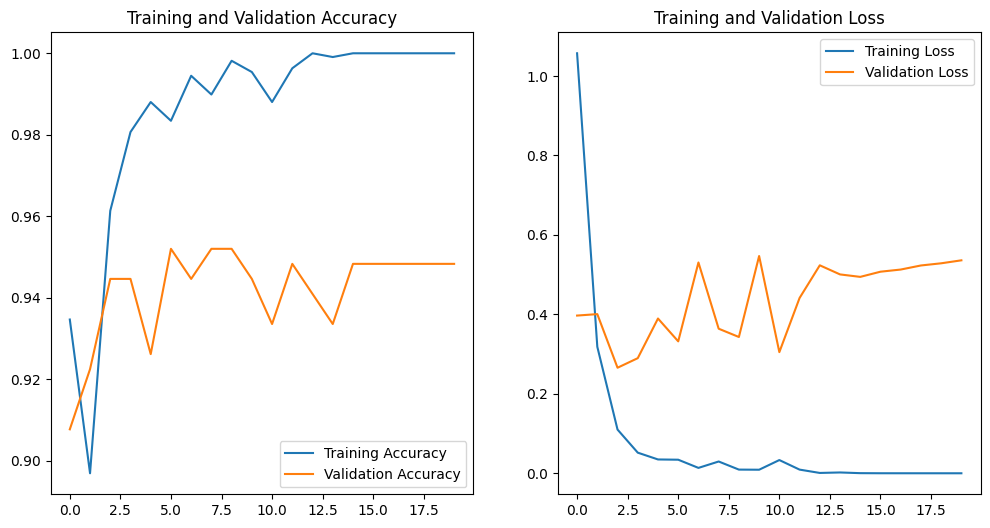

In [164]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(initial_epochs)

show_graph(history, 20)

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      6333
           1       0.92      0.92      0.92      5895

    accuracy                           0.92     12228
   macro avg       0.92      0.92      0.92     12228
weighted avg       0.92      0.92      0.92     12228

----------------------------------------------------------
Accuracy: 92.10%
----------------------------------------------------------
Precision: 92.10%
----------------------------------------------------------
Recall: 92.10%
----------------------------------------------------------


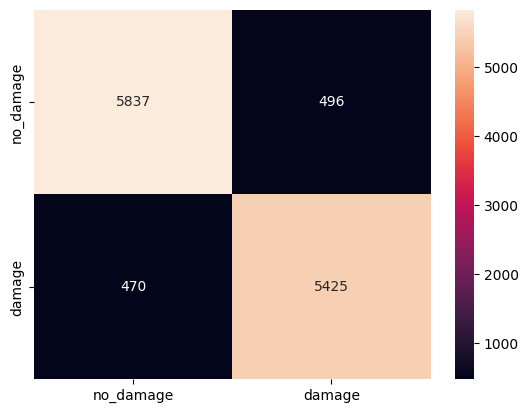

In [165]:
y_pred_VG = pd.DataFrame(y_pred_VG)[0].apply(lambda x : 1 if x > 0.5 else 0)

model_evaluation (y_true, y_pred_VG)

In [166]:
pretrained_model.trainable = True

# fine-tune from this layer onwards
fine_tune_at = 7

# freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [167]:
fine_tune_epochs3 = 20
total_epochs =  70

history = model_VG.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]+1,

    validation_data=val_ds,
)

y_true, y_pred_VG = eval_model_on_test(model_VG)

Epoch 51/70
34/34 [==============================] - 2s 63ms/step - loss: 5.1721e-05 - accuracy: 1.0000 - val_loss: 0.5436 - val_accuracy: 0.9483
Epoch 52/70
34/34 [==============================] - 3s 73ms/step - loss: 4.4808e-05 - accuracy: 1.0000 - val_loss: 0.5529 - val_accuracy: 0.9483
Epoch 53/70
34/34 [==============================] - 2s 63ms/step - loss: 3.8340e-05 - accuracy: 1.0000 - val_loss: 0.5611 - val_accuracy: 0.9483
Epoch 54/70
34/34 [==============================] - 2s 63ms/step - loss: 3.3907e-05 - accuracy: 1.0000 - val_loss: 0.5691 - val_accuracy: 0.9483
Epoch 55/70
34/34 [==============================] - 2s 64ms/step - loss: 2.9698e-05 - accuracy: 1.0000 - val_loss: 0.5763 - val_accuracy: 0.9483
Epoch 56/70
34/34 [==============================] - 2s 63ms/step - loss: 2.6497e-05 - accuracy: 1.0000 - val_loss: 0.5842 - val_accuracy: 0.9483
Epoch 57/70
34/34 [==============================] - 2s 72ms/step - loss: 2.3058e-05 - accuracy: 1.0000 - val_loss: 0.5908 -

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:   1%|          | 1/96 [00:00<01:15,  1.26it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:01<00:45,  2.06it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:01<00:35,  2.62it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:01<00:30,  2.99it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:01<00:32,  2.79it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:02<00:29,  3.07it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:02<00:31,  2.81it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:03<00:34,  2.55it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:03<00:32,  2.65it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:03<00:34,  2.53it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:04<00:33,  2.51it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:04<00:29,  2.81it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:04<00:26,  3.08it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:05<00:28,  2.88it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:05<00:29,  2.73it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:06<00:30,  2.64it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:06<00:30,  2.58it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:06<00:30,  2.54it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:07<00:27,  2.82it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:07<00:28,  2.71it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:07<00:28,  2.64it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:08<00:28,  2.57it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:08<00:28,  2.55it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:09<00:28,  2.52it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:09<00:28,  2.50it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:09<00:24,  2.80it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:10<00:25,  2.70it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:10<00:22,  2.99it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:10<00:23,  2.81it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:11<00:24,  2.71it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:11<00:24,  2.63it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:11<00:22,  2.90it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:12<00:20,  3.15it/s]

4/4 [==============================] - 0s 39ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:12<00:19,  3.26it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:12<00:20,  2.98it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:13<00:21,  2.81it/s]

4/4 [==============================] - 0s 39ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:13<00:19,  3.07it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:13<00:20,  2.83it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:14<00:21,  2.59it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:14<00:23,  2.40it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:15<00:20,  2.69it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:15<00:20,  2.63it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:15<00:20,  2.58it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:16<00:18,  2.89it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:16<00:16,  3.14it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:16<00:15,  3.31it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:17<00:16,  3.01it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:17<00:17,  2.79it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:17<00:17,  2.68it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:18<00:17,  2.62it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:18<00:17,  2.59it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:19<00:17,  2.55it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:19<00:17,  2.51it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:19<00:16,  2.50it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:20<00:14,  2.81it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:20<00:14,  2.71it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:21<00:14,  2.62it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:21<00:14,  2.57it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:21<00:14,  2.54it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:22<00:14,  2.52it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:22<00:12,  2.83it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:22<00:12,  2.70it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:23<00:11,  2.98it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:23<00:11,  2.81it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:23<00:10,  3.03it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:24<00:09,  3.24it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:24<00:09,  2.96it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:24<00:09,  2.80it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:25<00:10,  2.65it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:25<00:10,  2.46it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:26<00:09,  2.63it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:26<00:09,  2.49it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:27<00:09,  2.48it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:27<00:07,  2.79it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:27<00:06,  3.04it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:27<00:06,  3.27it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:28<00:06,  2.97it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:28<00:05,  3.17it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:28<00:05,  3.38it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:29<00:05,  3.03it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:29<00:04,  3.24it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:29<00:04,  3.40it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:30<00:04,  3.06it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:30<00:03,  3.26it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:30<00:03,  3.43it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:30<00:02,  3.58it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:31<00:02,  3.21it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:31<00:02,  2.98it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:31<00:02,  2.85it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:32<00:02,  2.75it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:32<00:01,  3.06it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:32<00:01,  3.31it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:33<00:00,  3.05it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:33<00:00,  2.88it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:34<00:00,  2.79it/s]

3/3 [==============================] - 0s 36ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:34<00:00,  2.80it/s]


              precision    recall  f1-score   support

           0       0.92      0.95      0.93      6333
           1       0.94      0.91      0.92      5895

    accuracy                           0.93     12228
   macro avg       0.93      0.93      0.93     12228
weighted avg       0.93      0.93      0.93     12228

----------------------------------------------------------
Accuracy: 92.84%
----------------------------------------------------------
Precision: 92.89%
----------------------------------------------------------
Recall: 92.84%
----------------------------------------------------------


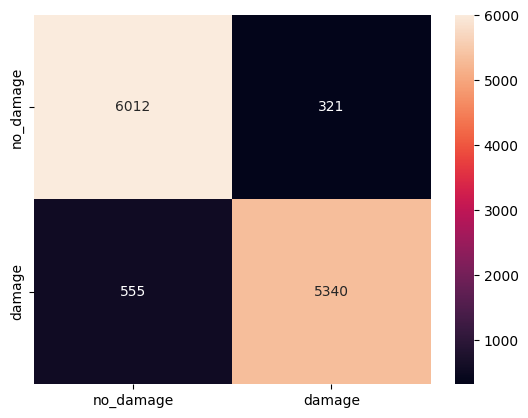

In [168]:
y_pred_VG = pd.DataFrame(y_pred_VG)[0].apply(lambda x : 1 if x > 0.5 else 0)

#show_graph(history, 20)

model_evaluation (y_true, y_pred_VG)

Epoch 71/90
34/34 [==============================] - 2s 72ms/step - loss: 6.0645e-06 - accuracy: 1.0000 - val_loss: 0.6597 - val_accuracy: 0.9483
Epoch 72/90
34/34 [==============================] - 2s 66ms/step - loss: 5.6742e-06 - accuracy: 1.0000 - val_loss: 0.6631 - val_accuracy: 0.9483
Epoch 73/90
34/34 [==============================] - 2s 65ms/step - loss: 5.4148e-06 - accuracy: 1.0000 - val_loss: 0.6658 - val_accuracy: 0.9483
Epoch 74/90
34/34 [==============================] - 2s 65ms/step - loss: 5.0095e-06 - accuracy: 1.0000 - val_loss: 0.6687 - val_accuracy: 0.9483
Epoch 75/90
34/34 [==============================] - 2s 65ms/step - loss: 4.7643e-06 - accuracy: 1.0000 - val_loss: 0.6706 - val_accuracy: 0.9483
Epoch 76/90
34/34 [==============================] - 2s 67ms/step - loss: 4.4506e-06 - accuracy: 1.0000 - val_loss: 0.6725 - val_accuracy: 0.9483
Epoch 77/90
34/34 [==============================] - 2s 65ms/step - loss: 4.3421e-06 - accuracy: 1.0000 - val_loss: 0.6748 -

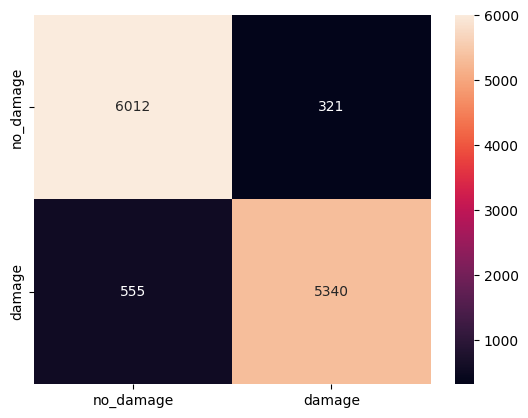

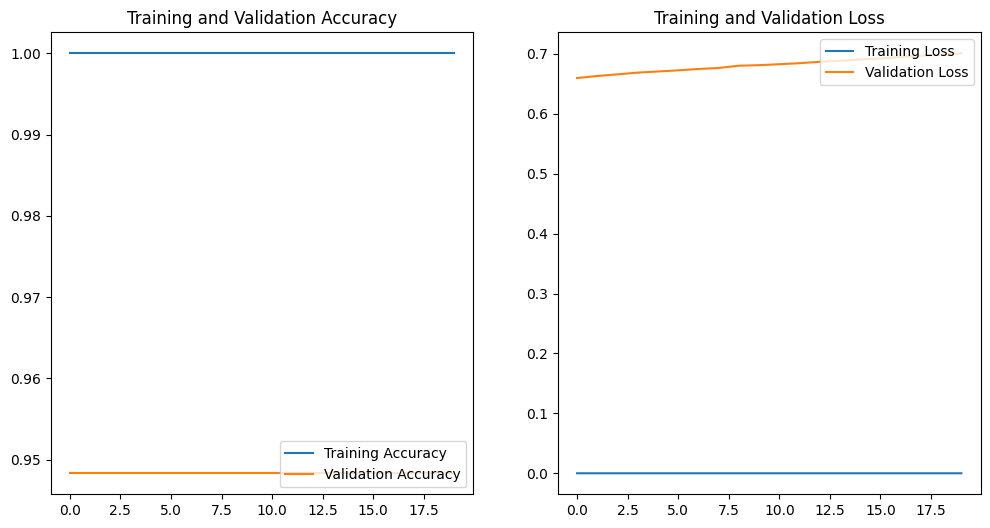

In [169]:
pretrained_model.trainable = True

# fine-tune from this layer onwards
fine_tune_at = 5

# freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable =  False

fine_tune_epochs4 = 20
total_epochs =  90

history = model_VG.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]+1,

    validation_data=val_ds,
)

#y_true, y_pred_VG = eval_model_on_test(model_VG)

y_pred_VG = pd.DataFrame(y_pred_VG)[0].apply(lambda x : 1 if x > 0.5 else 0)

model_evaluation (y_true, y_pred_VG)

show_graph(history, 20)

In [ ]:
pretrained_model.trainable = True

# fine-tune from this layer onwards
fine_tune_at = 3

# freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable =  False

fine_tune_epochs4 = 20
total_epochs =  110

history = model_VG.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]+1,

    validation_data=val_ds,
)

y_true, y_pred_VG = eval_model_on_test(model_VG)

y_pred_VG = pd.DataFrame(y_pred_VG)[0].apply(lambda x : 1 if x > 0.5 else 0)

model_evaluation (y_true, y_pred_VG)

show_graph(history, 20)

Epoch 111/130
34/34 [==============================] - 2s 65ms/step - loss: 1.0809e-06 - accuracy: 1.0000 - val_loss: 0.7252 - val_accuracy: 0.9483
Epoch 112/130
34/34 [==============================] - 2s 65ms/step - loss: 1.0570e-06 - accuracy: 1.0000 - val_loss: 0.7256 - val_accuracy: 0.9483
Epoch 113/130
34/34 [==============================] - 2s 64ms/step - loss: 1.0398e-06 - accuracy: 1.0000 - val_loss: 0.7275 - val_accuracy: 0.9483
Epoch 114/130
34/34 [==============================] - 2s 72ms/step - loss: 1.0099e-06 - accuracy: 1.0000 - val_loss: 0.7278 - val_accuracy: 0.9483
Epoch 115/130
34/34 [==============================] - 2s 65ms/step - loss: 9.8022e-07 - accuracy: 1.0000 - val_loss: 0.7290 - val_accuracy: 0.9483
Epoch 116/130
34/34 [==============================] - 2s 65ms/step - loss: 9.4216e-07 - accuracy: 1.0000 - val_loss: 0.7299 - val_accuracy: 0.9483
Epoch 117/130
34/34 [==============================] - 2s 65ms/step - loss: 9.2453e-07 - accuracy: 1.0000 - val_

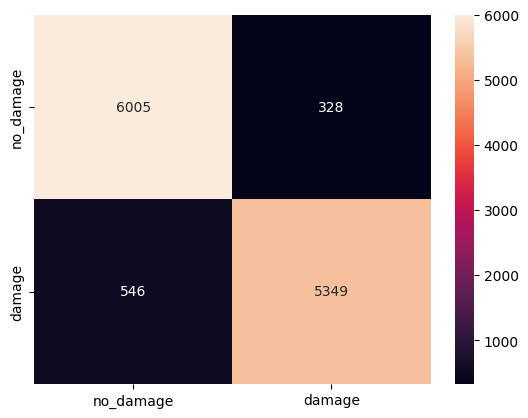

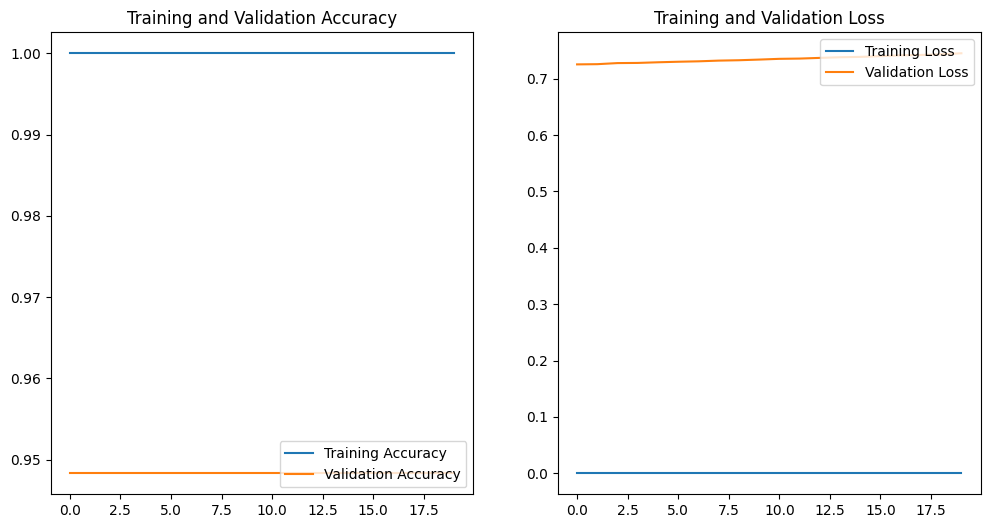

In [171]:
pretrained_model.trainable = True

# train all layers

fine_tune_epochs4 = 20
total_epochs =  130

history = model_VG.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]+1,

    validation_data=val_ds,
)

#y_true, y_pred_VG = eval_model_on_test(model_VG)

y_pred_VG = pd.DataFrame(y_pred_VG)[0].apply(lambda x : 1 if x > 0.5 else 0)

model_evaluation (y_true, y_pred_VG)

show_graph(history, 20)